In [12]:
from datetime import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
import math
from stravalib import Client

In [28]:
# The variables we expect to be loaded in .env (or Jupyter runtime environment)
# PATH_TO_INPUT_CSV=str representing filepath of input PG&E Green Button Hourly CSV
# PATH_TO_NEST_THERMOSTAT_CSV_ROOT_FOLDER=str Path representing root folder path to YYYY/MM/*.csv files from Nest (Google Takeout download)
load_dotenv()

True

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [16.0, 6.0]

In [25]:
# Adjust this to the bounds of your data set.
# This should ideally start and end at a boundary point that would contain full months of data
query_start = datetime(2018, 8, 1)
query_end =  datetime(2021, 1, 31)

## Load Strava data from API

In [37]:
# See docs: https://stravalib.readthedocs.io/en/latest/get-started/auth.html
client = Client()
client.authorization_url(client_id=os.getenv("STRAVA_CLIENT_ID"),
                         redirect_uri="http://localhost",
                        scope="activity:read_all")

'https://www.strava.com/oauth/authorize?client_id=3295&redirect_uri=http%3A%2F%2Flocalhost&approval_prompt=auto&response_type=code&scope=activity%3Aread_all'

Open the code above in a browser. Log into Strava, then click "Authorize app". Make note of the code in the URL you get redirected to (it will be a blank string, but the code should show up in the URL string as the `&code=....` fragment.

In [40]:
token = client.exchange_code_for_token(
    client_id=os.getenv("STRAVA_CLIENT_ID"),
    client_secret=os.getenv("STRAVA_CLIENT_SECRET"),
    code="<PASTE HERE>"
)

In [126]:
all_activities = [activity for activity in client.get_activities()]

In [127]:
# Back up the activity
import pickle
with open('all_activities.pkl', 'wb') as f:
    pickle.dump(all_activities, f)

## Data preprocessing and vis

In [129]:
has_power = [a for a in all_activities if (a.device_watts and a.type == 'Run')]

In [130]:
p = has_power[0]

In [131]:
stream = client.get_activity_streams(activity_id=p.id, types=['time' ,'distance', 'watts', 'velocity_smooth', 'heartrate', 'cadence', 'moving', 'grade_smooth', 'altitude'])

In [132]:
stream

{'watts': <Stream type=watts resolution=high original_size=302>,
 'moving': <Stream type=moving resolution=high original_size=302>,
 'velocity_smooth': <Stream type=velocity_smooth resolution=high original_size=302>,
 'grade_smooth': <Stream type=grade_smooth resolution=high original_size=302>,
 'cadence': <Stream type=cadence resolution=high original_size=302>,
 'distance': <Stream type=distance resolution=high original_size=302>,
 'heartrate': <Stream type=heartrate resolution=high original_size=302>,
 'altitude': <Stream type=altitude resolution=high original_size=302>,
 'time': <Stream type=time resolution=high original_size=302>}

In [137]:
df = pd.DataFrame({"watts": stream['watts'].data,
                   "time": stream['time'].data,
                   "distance": stream['distance'].data,
                   "watts": stream['watts'].data,
                   "velocity": stream['velocity_smooth'].data,
                   "grade": stream['grade_smooth'].data,
                   "heartrate": stream['heartrate'].data,
                   "cadence": stream['cadence'].data,
                  "altitude": stream['altitude'].data})

In [138]:
df.tail()

,watts,time,distance,velocity,grade,heartrate,cadence,altitude
297,0.0,352,831.9,0.038,9.7,101,42,241.6
298,27.0,353,832.2,0.082,9.7,101,42,241.6
299,29.0,354,832.2,0.080,12.3,102,42,241.8
300,30.0,355,832.2,0.088,31.3,102,42,241.8
301,31.0,356,832.4,0.114,34.2,102,42,241.8


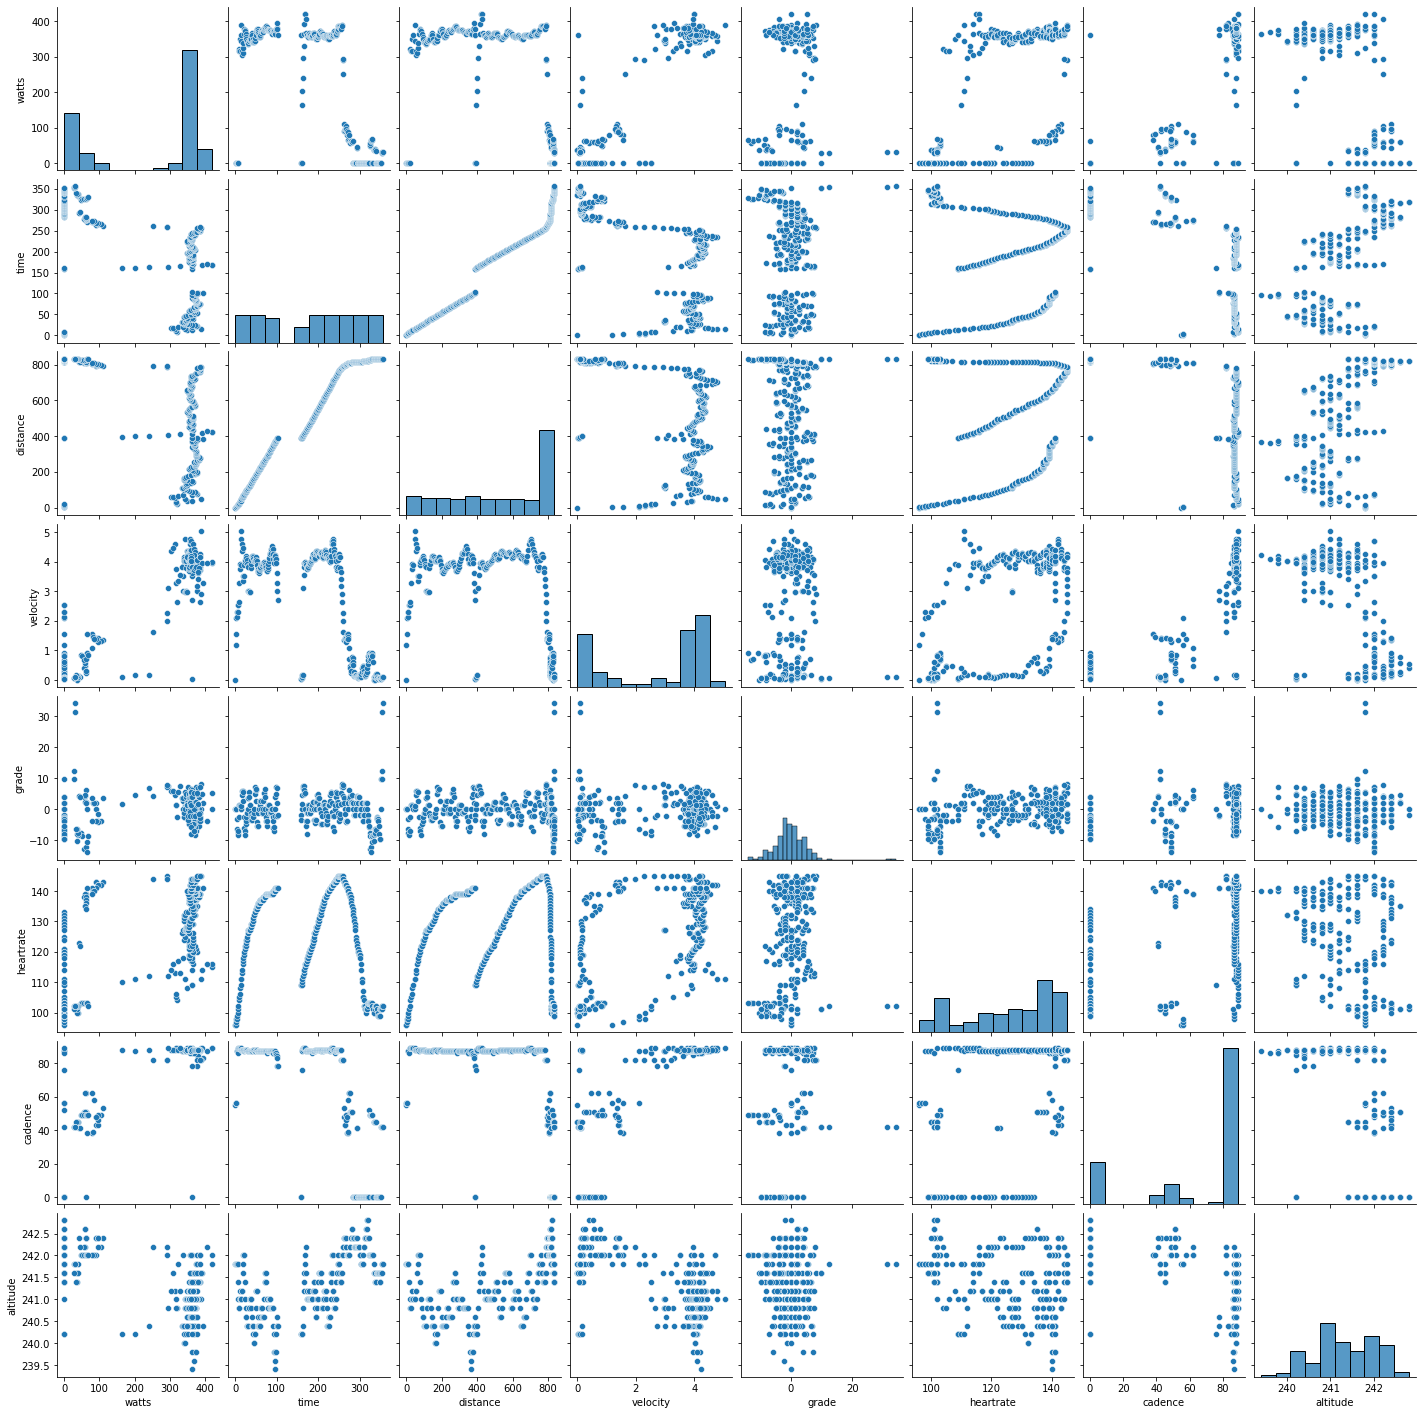

In [141]:
sns.pairplot(df)

In [5]:
df_csv = pd.read_csv(os.getenv('PATH_TO_INPUT_CSV'))

In [7]:
features_to_copy = {
    'date': 'DATE',
    'start_time': 'START TIME',
    'usage_kwh': 'USAGE',
    'cost_display': 'COST',
}

features = {
    'dt': lambda df: df.apply(lambda row: datetime.strptime(f'{row.date}T{row.start_time}', '%Y-%m-%dT%H:%M'), axis=1),
    'day_of_year': lambda df: df.dt.apply(lambda d: d.dayofyear),
    'day_of_week': lambda df: df.dt.apply(lambda d: d.dayofweek),
    'week_of_year': lambda df: df.dt.apply(lambda d: d.weekofyear),
    'year': lambda df: df.dt.apply(lambda d: d.year),
    'month': lambda df: df.dt.apply(lambda d: d.month),
    'hour': lambda df: df.dt.apply(lambda d: d.hour),
    'day_phase': lambda df: df.dt.apply(lambda d: math.floor(d.hour / 6)),
    'cost_cents': lambda df: df.cost_display.apply(lambda c: int(float(c[1:]) * 100))
}

In [8]:
df_energy = pd.DataFrame()

In [9]:
for newattr, oldattr in features_to_copy.items():
    df_energy[newattr] = df_csv[oldattr]

for attr, transform in features.items():
    df_energy[attr] = transform(df_energy)

In [10]:
# Truncate to dataset bounds
df_energy = df_energy[(df_energy.date >= query_start.strftime('%Y-%m-%d')) & (df_energy.date <= query_end.strftime('%Y-%m-%d'))]

In [34]:
# Preview data
df_energy.head(n=20)

,date,start_time,usage_kwh,cost_display,dt,day_of_year,day_of_week,week_of_year,year,month,hour,day_phase,cost_cents
600,2018-08-01,00:00,0.24,$0.05,2018-08-01 00:00:00,213,2,31,2018,8,0,0,5
601,2018-08-01,01:00,0.24,$0.04,2018-08-01 01:00:00,213,2,31,2018,8,1,0,4
602,2018-08-01,02:00,0.34,$0.06,2018-08-01 02:00:00,213,2,31,2018,8,2,0,6
603,2018-08-01,03:00,0.40,$0.07,2018-08-01 03:00:00,213,2,31,2018,8,3,0,7
604,2018-08-01,04:00,0.58,$0.11,2018-08-01 04:00:00,213,2,31,2018,8,4,0,11
605,2018-08-01,05:00,0.25,$0.05,2018-08-01 05:00:00,213,2,31,2018,8,5,0,5
606,2018-08-01,06:00,0.40,$0.07,2018-08-01 06:00:00,213,2,31,2018,8,6,1,7
607,2018-08-01,07:00,1.85,$0.35,2018-08-01 07:00:00,213,2,31,2018,8,7,1,35
608,2018-08-01,08:00,0.40,$0.07,2018-08-01 08:00:00,213,2,31,2018,8,8,1,7
609,2018-08-01,09:00,0.22,$0.04,2018-08-01 09:00:00,213,2,31,2018,8,9,1,4


### Quick sanity check of data

<AxesSubplot:xlabel='month', ylabel='usage_kwh'>

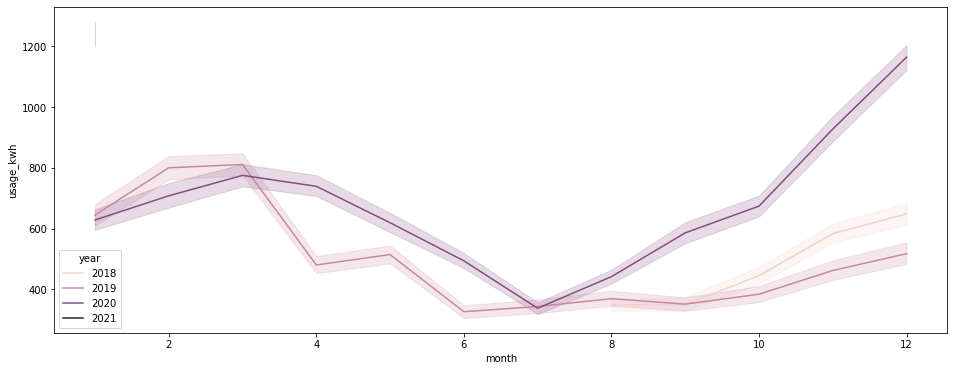

In [11]:
sns.lineplot(data=df_energy, x='month', y='usage_kwh', hue="year", estimator=np.sum)

<AxesSubplot:xlabel='month', ylabel='cost_cents'>

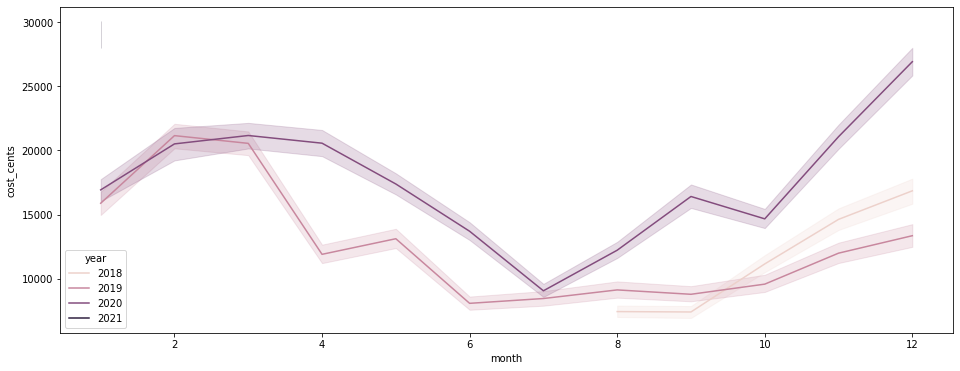

In [12]:
sns.lineplot(data=df_energy, x='month', y='cost_cents', hue="year", estimator=np.sum)